In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import wb
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 


In [2]:

print("Сбор экономических данных по Австралии за 1992-2024 годы...")

# Обновленный список показателей
indicators = {
    # Основные макроэкономические показатели
    'GDP_Nominal_USD': 'NY.GDP.MKTP.CD',          # X(t) - ВВП
    'Population': 'SP.POP.TOTL',                  # Население
    'Labor_Force': 'SL.TLF.TOTL.IN',              # L(t) - Трудовые ресурсы
    'Investments_USD': 'NE.GDI.FTOT.CD',          # I(t) - Инвестиции
    'Household_Consumption_USD': 'NE.CON.PRVT.CD', # Потребление домохозяйств
    'Government_Consumption_USD': 'NE.CON.GOVT.CD', # Гос. потребление
    'Exports_USD': 'NE.EXP.GNFS.CD',              # Экспорт
    'Imports_USD': 'NE.IMP.GNFS.CD',              # Импорт
    'AUD_USD_Exchange_Rate': 'PA.NUS.FCRF',       # Z(t) - Курс AUD/USD
    'AU_Inflation_PCT': 'FP.CPI.TOTL.ZG',         # Инфляция Австралии (%)
    'AU_Inflation_Index': 'FP.CPI.TOTL',          # Инфляция Австралии (индекс)
}

# Загружаем данные
wb_data = {}
for name, code in indicators.items():
    try:
        series = wb.download(indicator=code, country=['AU'], start=1992, end=2024)
        if not series.empty:
            values = series.reset_index()
            values = values[['year', code]].rename(columns={'year': 'Year', code: name})
            wb_data[name] = values.set_index('Year')[name]
            print(f"{name} - загружено")
        else:
            print(f"{name} - нет данных")
    except Exception as e:
        print(f"{name} - ошибка: {e}")

# Создаем основной DataFrame
df = pd.DataFrame(wb_data)
df = df.sort_index()  # Сортируем по годам

print(f"Загружено данных: {len(df)} лет ({df.index.min()}-{df.index.max()})")

# Дозагружаем инфляцию США ОТДЕЛЬНО
print("Загрузка инфляции США...")
try:
    us_inflation = wb.download(indicator='FP.CPI.TOTL', country=['US'], start=1992, end=2024)
    if not us_inflation.empty:
        us_inflation = us_inflation.reset_index()
        us_inflation = us_inflation[['year', 'FP.CPI.TOTL']].rename(columns={'year': 'Year', 'FP.CPI.TOTL': 'US_Inflation_Index'})
        us_inflation = us_inflation.set_index('Year')['US_Inflation_Index']
        
        # Объединяем с основным DataFrame
        df = df.join(us_inflation, how='left')
        print("US_Inflation_Index загружена")
        print(f"Доступно данных по инфляции США: {df['US_Inflation_Index'].notna().sum()} лет")
    else:
        print("US_Inflation_Index - нет данных")
        df['US_Inflation_Index'] = np.nan
except Exception as e:
    print(f"US_Inflation_Index - ошибка: {e}")
    df['US_Inflation_Index'] = np.nan

# Расчет основных показателей
print("Расчет основных показателей:")

# 1. Определяем L(t) - Трудовые ресурсы (ПРЕДВАРИТЕЛЬНО, потом пересчитаем)
df['L_t'] = df['Labor_Force']
print("L(t) - Трудовые ресурсы рассчитаны")

# 2. Расчет C(t) - Потребление
df['C_t'] = df['Household_Consumption_USD'] + df['Government_Consumption_USD']
print("C(t) - Потребление рассчитано")

# 3. Расчет I(t) - Инвестиции
df['I_t'] = df['Investments_USD']
print("I(t) - Инвестиции определены")

# 4. Расчет X(t) - ВВП
df['X_t'] = df['GDP_Nominal_USD']
print("X(t) - ВВП определен")

# 5. Расчет Z(t) - Курс
df['Z_t'] = df['AUD_USD_Exchange_Rate']
print("Z(t) - Курс определен")

# Проверяем пропуски
print("Проверка пропусков данных:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

# Показываем текущее состояние данных
print("Основные показатели готовы:")
print(f"X(t) - ВВП: {df['X_t'].notna().sum()} лет данных")
print(f"L(t) - Трудовые ресурсы: {df['L_t'].notna().sum()} лет данных") 
print(f"C(t) - Потребление: {df['C_t'].notna().sum()} лет данных")
print(f"I(t) - Инвестиции: {df['I_t'].notna().sum()} лет данных")
print(f"Z(t) - Курс: {df['Z_t'].notna().sum()} лет данных")
print(f"Инфляция США: {df['US_Inflation_Index'].notna().sum()} лет данных")

print("Расчет капитала K(t) с амортизацией 5%...")

# Параметры для расчета капитала
depreciation_rate = 0.05  # 5% годовая амортизация

# Сортируем данные по годам для корректного расчета
df = df.sort_index()

# Расчет начального капитала (K0) - оцениваем как 3×ВВП первого года
first_year = df.index[0]
initial_capital = df.loc[first_year, 'X_t'] * 3
df.loc[first_year, 'K_t'] = initial_capital

print(f"Начальный капитал ({first_year} год): {initial_capital:,.0f} USD")

# Расчет капитала для последующих лет с амортизацией
for i in range(1, len(df)):
    prev_year = df.index[i-1]
    current_year = df.index[i]
    
    # K(t) = (1 - δ) × K(t-1) + I(t)
    df.loc[current_year, 'K_t'] = (df.loc[prev_year, 'K_t'] * (1 - depreciation_rate) 
                                 + df.loc[current_year, 'I_t'])

print("K(t) - Капитал рассчитан")

# Проверяем соотношение C(t) < K(t)
print("Проверка: C(t) < K(t)")
c_less_than_k = (df['C_t'] < df['K_t']).all()
print(f"Потребление всегда меньше капитала: {c_less_than_k}")

if not c_less_than_k:
    problematic_years = df[df['C_t'] >= df['K_t']].index.tolist()
    print(f"Проблемные годы: {problematic_years}")

# Показываем основные показатели
print("Основные показатели за весь период:")
print(f"X(t) - ВВП: {df['X_t'].min():,.0f} - {df['X_t'].max():,.0f} USD")
print(f"K(t) - Капитал: {df['K_t'].min():,.0f} - {df['K_t'].max():,.0f} USD") 
print(f"L(t) - Трудовые ресурсы: {df['L_t'].min():,.0f} - {df['L_t'].max():,.0f} чел.")
print(f"C(t) - Потребление: {df['C_t'].min():,.0f} - {df['C_t'].max():,.0f} USD")
print(f"I(t) - Инвестиции: {df['I_t'].min():,.0f} - {df['I_t'].max():,.0f} USD")

# Соотношение капитала к ВВП (важный макроэкономический показатель)
capital_to_gdp_ratio = df['K_t'] / df['X_t']
print(f"Среднее соотношение Капитал/ВВП: {capital_to_gdp_ratio.mean():.2f}")

Сбор экономических данных по Австралии за 1992-2024 годы...
GDP_Nominal_USD - загружено
Population - загружено
Labor_Force - загружено
Investments_USD - загружено
Household_Consumption_USD - загружено
Government_Consumption_USD - загружено
Exports_USD - загружено
Imports_USD - загружено
AUD_USD_Exchange_Rate - загружено
AU_Inflation_PCT - загружено
AU_Inflation_Index - загружено
Загружено данных: 33 лет (1992-2024)
Загрузка инфляции США...
US_Inflation_Index загружена
Доступно данных по инфляции США: 33 лет
Расчет основных показателей:
L(t) - Трудовые ресурсы рассчитаны
C(t) - Потребление рассчитано
I(t) - Инвестиции определены
X(t) - ВВП определен
Z(t) - Курс определен
Проверка пропусков данных:
Series([], dtype: int64)
Основные показатели готовы:
X(t) - ВВП: 33 лет данных
L(t) - Трудовые ресурсы: 33 лет данных
C(t) - Потребление: 33 лет данных
I(t) - Инвестиции: 33 лет данных
Z(t) - Курс: 33 лет данных
Инфляция США: 33 лет данных
Расчет капитала K(t) с амортизацией 5%...
Начальный ка

In [3]:
print("Дисконтирование данных на инфляцию США...")

# Базовый год = 1993 
base_year = 1993

# Проверяем тип индекса
print(f"Тип индекса: {type(df.index[0])}")
print(f"Первые значения индекса: {df.index[:5].tolist()}")

# Находим индекс инфляции для базового года 
base_year_str = str(base_year)
base_inflation_index = df.loc[base_year_str, 'US_Inflation_Index']
print(f"Базовый год: {base_year}")
print(f"Индекс инфляции в базовом году: {base_inflation_index:.2f}")

# Расчет реальных показателей в ценах 1993 года
print("\nРасчет реальных показателей в постоянных ценах 1993 года:")

# 1. Реальный ВВП
df['X_real'] = df['X_t'] * (base_inflation_index / df['US_Inflation_Index'])
print("X_real - Реальный ВВП рассчитан")

# 2. Реальный капитал
df['K_real'] = df['K_t'] * (base_inflation_index / df['US_Inflation_Index'])
print("K_real - Реальный капитал рассчитан")

# 3. Реальное потребление
df['C_real'] = df['C_t'] * (base_inflation_index / df['US_Inflation_Index'])
print("C_real - Реальное потребление рассчитан")

# 4. Реальные инвестиции
df['I_real'] = df['I_t'] * (base_inflation_index / df['US_Inflation_Index'])
print("I_real - Реальные инвестиции рассчитаны")

# Проверяем изменения
print(f"\nСравнение номинальных и реальных показателей:")
last_year = df.index[-1]
print(f"Номинальный ВВП {last_year}: {df.loc[last_year, 'X_t']:,.0f} USD")
print(f"Реальный ВВП {last_year}: {df.loc[last_year, 'X_real']:,.0f} USD (в ценах 1993)")

print(f"Номинальный ВВП {base_year_str}: {df.loc[base_year_str, 'X_t']:,.0f} USD")
print(f"Реальный ВВП {base_year_str}: {df.loc[base_year_str, 'X_real']:,.0f} USD (в ценах 1993)")

# Расчет темпов роста реального ВВП
df['X_real_growth'] = df['X_real'].pct_change() * 100
print("Темпы роста реального ВВП рассчитаны")

# Показываем результаты
print(f"\nРеальный ВВП (в ценах 1993 года):")
print(f"Начало периода ({df.index[0]}): {df['X_real'].iloc[0]:,.0f} USD")
print(f"Конец периода ({df.index[-1]}): {df['X_real'].iloc[-1]:,.0f} USD")
print(f"Общий рост: {((df['X_real'].iloc[-1] / df['X_real'].iloc[0]) - 1) * 100:.1f}%")

# Сохраняем финальные данные
final_columns = {
    'X_t': 'X_nominal_USD',
    'X_real': 'X_real_1993_USD', 
    'K_t': 'K_nominal_USD',
    'K_real': 'K_real_1993_USD',
    'L_t': 'L_employment',
    'C_t': 'C_nominal_USD', 
    'C_real': 'C_real_1993_USD',
    'I_t': 'I_nominal_USD',
    'I_real': 'I_real_1993_USD',
    'Z_t': 'AUD_USD_Exchange_Rate',
    'US_Inflation_Index': 'US_CPI_Index'
}

final_df = df[list(final_columns.keys())].rename(columns=final_columns)
final_df.to_csv('australia_economic_data_final.csv')
print(f"\nФинальные данные сохранены: 'australia_economic_data_final.csv'")

print("\nГОТОВО! Все данные подготовлены для модельного анализа:")
print("Номинальные показатели в USD")
print("Реальные показатели в ценах 1993 года") 
print("Капитал рассчитан с амортизацией 5%")
print("Все данные дисконтированы на инфляцию США")

# Загрузка salary data и правильный расчет L(t)
salary_data = pd.read_csv('statbase_chart.csv')
salary_data['Year'] = salary_data['Year'].astype(int)
salary_data = salary_data.set_index('Year')

# Исправление: правильный расчет L(t)
print("\nИСПРАВЛЕНИЕ: Пересчет L(t) согласно заданию")
print("L(t) = Трудовые ресурсы × Годовая зарплата")

# Приводим индексы к одному типу для безопасного объединения
print("Приведение индексов к одному типу...")
df.index = df.index.astype(int)

# Правильный расчет L(t) по заданию
df['L_t'] = df['Labor_Force'] * (salary_data['Salary'] * 12)
print("L(t) пересчитан как: Трудовые ресурсы × (Среднемесячная зарплата × 12)")

# Проверяем осмысленность
labor_share = (df['L_t'] / df['X_real']).mean() * 100
print(f"Проверка: Доля труда в ВВП = {labor_share:.1f}%")

if 50 < labor_share < 80:
    print("Данные реалистичны (доля труда 50-80%)")
else:
    print("Проверь исходные данные - нереалистичная доля труда")

Дисконтирование данных на инфляцию США...
Тип индекса: <class 'str'>
Первые значения индекса: ['1992', '1993', '1994', '1995', '1996']
Базовый год: 1993
Индекс инфляции в базовом году: 66.25

Расчет реальных показателей в постоянных ценах 1993 года:
X_real - Реальный ВВП рассчитан
K_real - Реальный капитал рассчитан
C_real - Реальное потребление рассчитан
I_real - Реальные инвестиции рассчитаны

Сравнение номинальных и реальных показателей:
Номинальный ВВП 2024: 1,752,193,307,380 USD
Реальный ВВП 2024: 806,910,855,488 USD (в ценах 1993)
Номинальный ВВП 1993: 312,133,923,553 USD
Реальный ВВП 1993: 312,133,923,553 USD (в ценах 1993)
Темпы роста реального ВВП рассчитаны

Реальный ВВП (в ценах 1993 года):
Начало периода (1992): 335,133,772,110 USD
Конец периода (2024): 806,910,855,488 USD
Общий рост: 140.8%

Финальные данные сохранены: 'australia_economic_data_final.csv'

ГОТОВО! Все данные подготовлены для модельного анализа:
Номинальные показатели в USD
Реальные показатели в ценах 1993 г

In [ ]:
# Создаем данные для регрессии
regression_data = pd.DataFrame({
    'X': df['X_real'],
    'K': df['K_real'],  
    'L': df['L_t']  # ← ТЕПЕРЬ это ПРАВИЛЬНЫЙ L(t) со стоимостью труда!
})

regression_data = regression_data.merge(
    salary_data[['Salary']], 
    left_index=True, 
    right_index=True, 
    how='left'
)

print("\nДанные для регрессии готовы:")
print(f"Размер: {regression_data.shape}")
print(f"Годы: {regression_data.index.min()}-{regression_data.index.max()}")

# Преобразуем все необходимые столбцы в числовой формат
regression_data['L'] = pd.to_numeric(regression_data['L'], errors='coerce')
regression_data['Salary'] = pd.to_numeric(regression_data['Salary'], errors='coerce')
regression_data['K'] = pd.to_numeric(regression_data['K'], errors='coerce')
regression_data['X'] = pd.to_numeric(regression_data['X'], errors='coerce')

# Удалим строки с пропущенными значениями, если они есть
regression_data = regression_data.dropna(subset=['L', 'Salary', 'K', 'X'])

# 🔧 ИСПРАВЛЕНИЕ: УБИРАЕМ НЕПРАВИЛЬНЫЙ РАСЧЕТ L_cost
# УДАЛЕНО: regression_data['L_cost'] = regression_data['L'] * regression_data['Salary']

# Пересчитываем логарифмы с ПРАВИЛЬНОЙ переменной L (убедимся, что значения положительные)
print(f"\n Проверка минимальных значений перед логарифмированием:")
print(f"Минимальное L: {regression_data['L'].min():.2f}")
print(f"Минимальное K: {regression_data['K'].min():.2f}")
print(f"Минимальное X: {regression_data['X'].min():.2f}")

# Убедимся, что все значения положительные для логарифмирования
if (regression_data['L'] <= 0).any() or (regression_data['K'] <= 0).any() or (regression_data['X'] <= 0).any():
    print("Внимание: есть неположительные значения! Исправляем...")
    regression_data = regression_data[(regression_data['L'] > 0) & (regression_data['K'] > 0) & (regression_data['X'] > 0)]

# Теперь безопасно рассчитываем логарифмы
regression_data['ln_L'] = np.log(regression_data['L'])  # ← ПРАВИЛЬНЫЙ L!
regression_data['ln_K'] = np.log(regression_data['K'])
regression_data['ln_X'] = np.log(regression_data['X'])

print(f"\n Логарифмы рассчитаны")
print(f"Диапазон ln_L: [{regression_data['ln_L'].min():.2f}, {regression_data['ln_L'].max():.2f}]")
print(f"Диапазон ln_K: [{regression_data['ln_K'].min():.2f}, {regression_data['ln_K'].max():.2f}]")
print(f"Диапазон ln_X: [{regression_data['ln_X'].min():.2f}, {regression_data['ln_X'].max():.2f}]")

# 🔧 ИСПРАВЛЕНИЕ: ЕДИНСТВЕННАЯ РЕГРЕССИЯ с правильной спецификацией
X = regression_data[['ln_K', 'ln_L']]  # ← ПРАВИЛЬНЫЕ ПЕРЕМЕННЫЕ!
y = regression_data['ln_X']

print(f"\nРазмеры данных для регрессии:")
print(f"X: {X.shape}, y: {y.shape}")

model = LinearRegression()
model.fit(X, y)  # ← ОДИН РАЗ обучаем модель!

# 🔧 ИСПРАВЛЕНИЕ: СОХРАНЯЕМ ПАРАМЕТРЫ
α = model.coef_[0]  # эластичность по капиталу
β = model.coef_[1]  # эластичность по труду (уже включая зарплату!)
intercept = model.intercept_
A = np.exp(intercept)

print(f"\n РАССЧИТАННЫЕ ПАРАМЕТРЫ МОДЕЛИ:")
print(f"α (эластичность по капиталу) = {α:.4f}")
print(f"β (эластичность по труду) = {β:.4f}")
print(f"intercept = {intercept:.4f}")
print(f"A = {A:.4f}")
print(f"α + β = {α+β:.4f} (отдача от масштаба)")
print(f"R² = {model.score(X, y):.4f}")

# Пересчитываем прогноз с ПРАВИЛЬНЫМИ параметрами
regression_data['X_pred'] = np.exp(intercept + α * regression_data['ln_K'] + β * regression_data['ln_L'])

# Проверяем качество прогноза
mse = ((regression_data['X'] - regression_data['X_pred']) ** 2).mean()
rmse = np.sqrt(mse)
print(f"RMSE прогноза: {rmse:.2f}")


Данные для регрессии готовы:
Размер: (33, 4)
Годы: 1992-2024

 Проверка минимальных значений перед логарифмированием:
Минимальное L: 210043077191.64
Минимальное K: 1001053964705.34
Минимальное X: 309717335492.19

 Логарифмы рассчитаны
Диапазон ln_L: [26.07, 27.64]
Диапазон ln_K: [27.63, 28.50]
Диапазон ln_X: [26.46, 27.61]

Размеры данных для регрессии:
X: (33, 2), y: (33,)

 РАССЧИТАННЫЕ ПАРАМЕТРЫ МОДЕЛИ:
α (эластичность по капиталу) = 0.1552
β (эластичность по труду) = 0.6282
intercept = 5.7733
A = 321.5893
α + β = 0.7834 (отдача от масштаба)
R² = 0.9376
RMSE прогноза: 69255604475.50


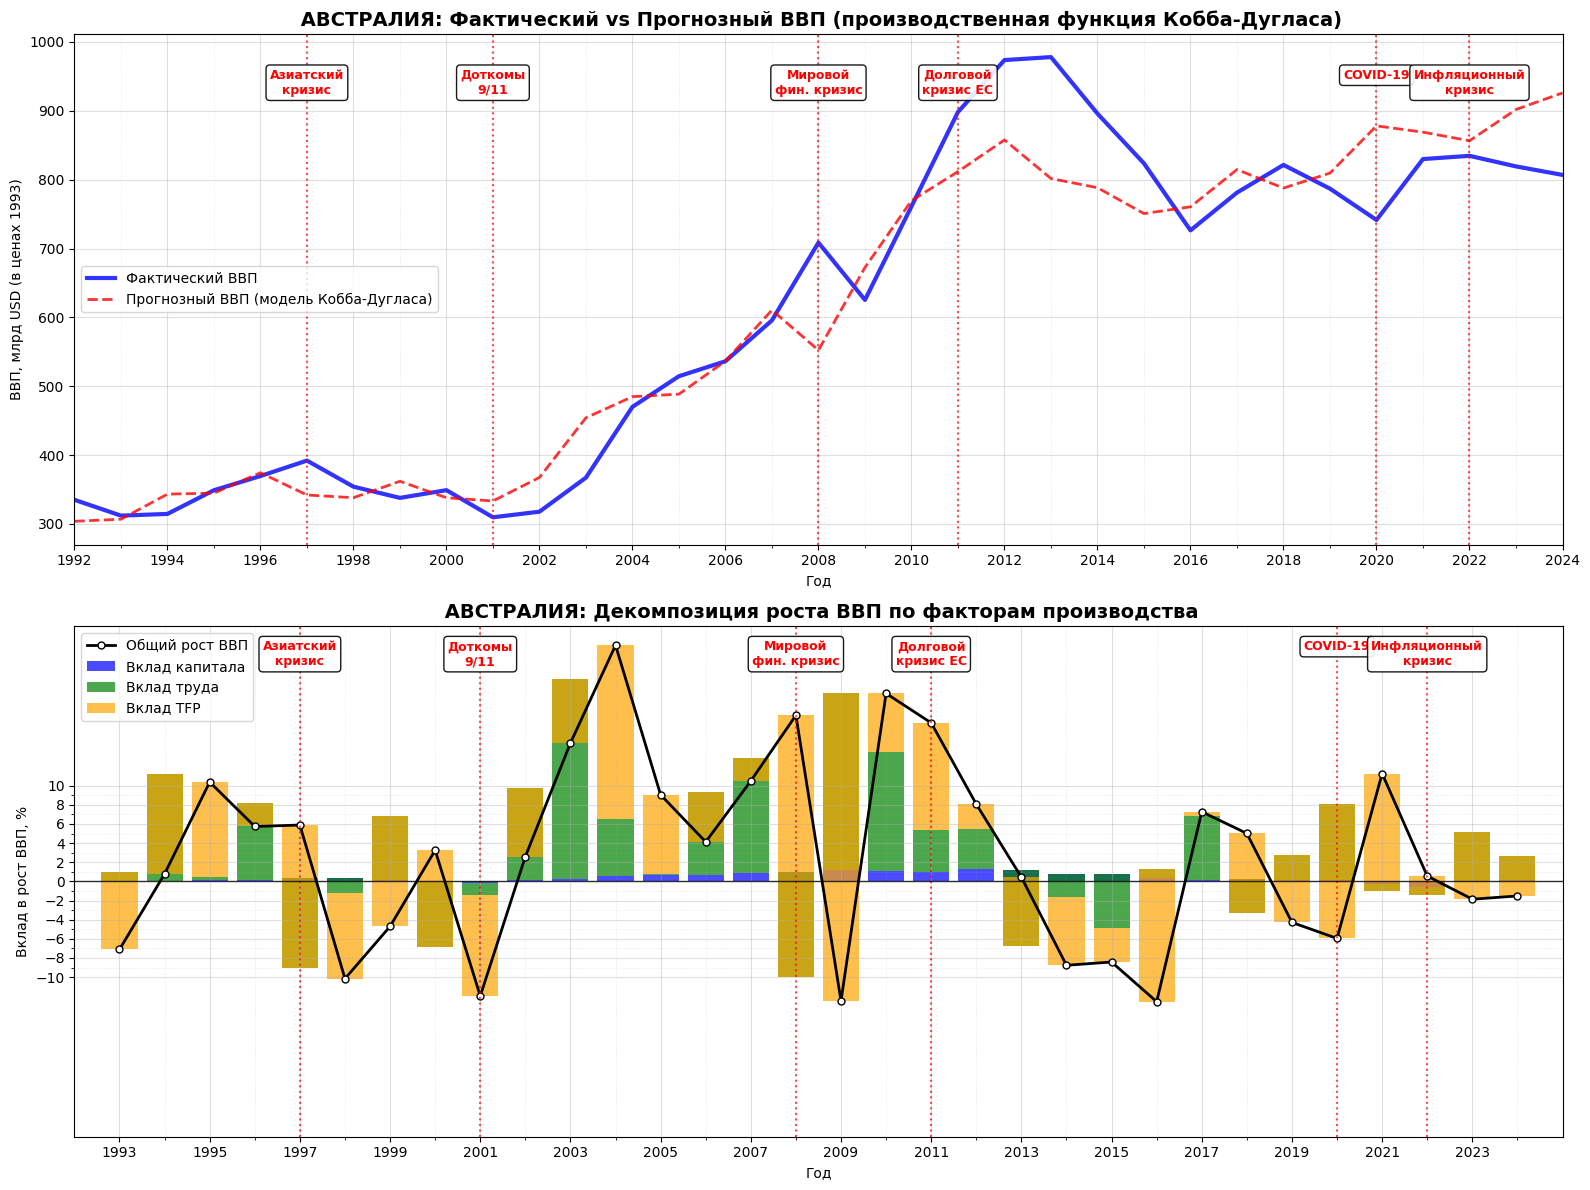

 АНАЛИЗ АВСТРАЛИИ:
Расчетные параметры: α = 0.1552, β = 0.6282

 СРЕДНИЕ ПОКАЗАТЕЛИ ЗА ВЕСЬ ПЕРИОД:
Средний рост ВВП: 2.75%
Вклад капитала: 0.40% (14.5%)
Вклад труда: 3.08% (112.3%)
Вклад TFP: -0.74% (-26.8%)


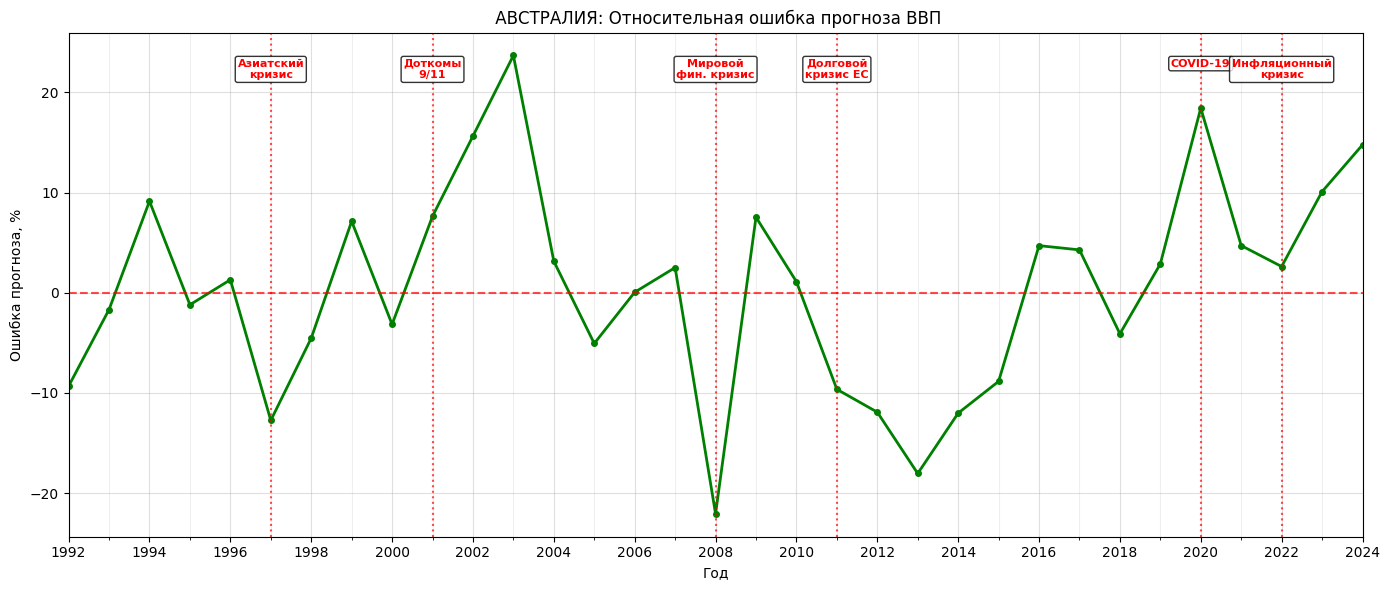


 СТАТИСТИКА ОШИБКИ ПРОГНОЗА:
Средняя абсолютная ошибка: 8.05%
Максимальная переоценка: 23.67%
Максимальная недооценка: -22.05%
Стандартное отклонение: 10.30%

 АНАЛИЗ ОШИБОК В КРИЗИСНЫЕ ПЕРИОДЫ:
1997 - Азиатский
кризис: -12.74%
2001 - Доткомы
9/11: +7.64%
2008 - Мировой
фин. кризис: -22.05%
2011 - Долговой
кризис ЕС: -9.63%
2020 - COVID-19: +18.43%
2022 - Инфляционный
кризис: +2.62%


In [5]:
# Создаем отдельные графики
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Кризисные годы (вертикальные красные линии)
crisis_years = [1997, 2001, 2008, 2011, 2020, 2022]
crisis_labels = {
    1997: 'Азиатский\nкризис',
    2001: 'Доткомы\n9/11',
    2008: 'Мировой\nфин. кризис', 
    2011: 'Долговой\nкризис ЕС',
    2020: 'COVID-19',
    2022: 'Инфляционный\nкризис'
}

# ГРАФИК 1: Фактический vs Прогнозный ВВП (с ПРАВИЛЬНЫМИ параметрами)
years_int = regression_data.index.astype(int)
ax1.plot(years_int, regression_data['X']/1e9, 'b-', 
         label='Фактический ВВП', linewidth=3, alpha=0.8)
ax1.plot(years_int, regression_data['X_pred']/1e9, 'r--', 
         label='Прогнозный ВВП (модель Кобба-Дугласа)', linewidth=2, alpha=0.8)

# Добавляем вертикальные линии кризисов
for year in crisis_years:
    if year in years_int.values:
        ax1.axvline(x=year, color='red', linestyle=':', alpha=0.7, linewidth=1.5)
        ax1.text(year, ax1.get_ylim()[1]*0.95, crisis_labels[year], 
                ha='center', va='top', fontsize=9, color='red', fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9))

# Настройка сетки и шкалы для первого графика
ax1.set_xlabel('Год')
ax1.set_ylabel('ВВП, млрд USD (в ценах 1993)')
ax1.set_title(' АВСТРАЛИЯ: Фактический vs Прогнозный ВВП (производственная функция Кобба-Дугласа)', 
              fontsize=14, fontweight='bold')

# Частая сетка по годам - НАЧИНАЕМ С 1992
ax1.set_xticks(range(1992, 2025, 2))  # Каждые 2 года начиная с 1992
ax1.set_xticks(range(1992, 2025, 1), minor=True)  # Каждый год (второстепенные)
ax1.grid(True, which='major', alpha=0.4, linestyle='-', linewidth=0.8)
ax1.grid(True, which='minor', alpha=0.2, linestyle='--', linewidth=0.5)

ax1.legend()
ax1.set_xlim(1992, 2024)  # ОБЕСПЕЧИВАЕМ ВИДИМОСТЬ 1992 ГОДА

# ГРАФИК 2: Вклад факторов в рост ВВП (с ПРАВИЛЬНЫМИ параметрами)
growth_data = pd.DataFrame({
    'year': regression_data.index.astype(int),
    'capital_growth': α * regression_data['ln_K'].diff() * 100,
    'labor_growth': β * regression_data['ln_L'].diff() * 100,  # ← ПРАВИЛЬНЫЙ L!
    'total_growth': regression_data['ln_X'].diff() * 100
})

growth_data['tfp_growth'] = growth_data['total_growth'] - (growth_data['capital_growth'] + growth_data['labor_growth'])
growth_data = growth_data.dropna()

# Столбчатая диаграмма вкладов
years_growth = growth_data['year']
bar_width = 0.8

bars1 = ax2.bar(years_growth, growth_data['capital_growth'], bar_width, 
                label='Вклад капитала', color='blue', alpha=0.7)
bars2 = ax2.bar(years_growth, growth_data['labor_growth'], bar_width, 
                bottom=growth_data['capital_growth'],
                label='Вклад труда', color='green', alpha=0.7)
bars3 = ax2.bar(years_growth, growth_data['tfp_growth'], bar_width, 
                bottom=growth_data['capital_growth'] + growth_data['labor_growth'],
                label='Вклад TFP', color='orange', alpha=0.7)

# Добавляем общий рост линией
line = ax2.plot(years_growth, growth_data['total_growth'], 'k-', linewidth=2, marker='o', 
                markersize=5, label='Общий рост ВВП', markerfacecolor='white', markeredgecolor='black')

# Вертикальные линии кризисов
for year in crisis_years:
    if year in years_growth.values:
        ax2.axvline(x=year, color='red', linestyle=':', alpha=0.7, linewidth=1.5)
        ax2.text(year, ax2.get_ylim()[1]*0.95, crisis_labels[year], 
                ha='center', va='top', fontsize=9, color='red', fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9))

# Настройка сетки и шкалы для второго графика
ax2.set_xlabel('Год')
ax2.set_ylabel('Вклад в рост ВВП, %')
ax2.set_title(' АВСТРАЛИЯ: Декомпозиция роста ВВП по факторам производства', 
              fontsize=14, fontweight='bold')

# Частая сетка по годам - НАЧИНАЕМ С 1993 (первый год с данными роста)
ax2.set_xticks(range(1993, 2025, 2))  # Каждые 2 года начиная с 1993
ax2.set_xticks(range(1993, 2025, 1), minor=True)  # Каждый год (второстепенные)

# Сетка по вертикали - каждые 2%
y_max = max(growth_data['total_growth'].max(), abs(growth_data['total_growth'].min())) + 2
y_ticks_major = np.arange(-10, 11, 2)  # Каждые 2%
y_ticks_minor = np.arange(-10, 11, 1)  # Каждые 1%

ax2.set_yticks(y_ticks_major)
ax2.set_yticks(y_ticks_minor, minor=True)
ax2.set_ylim(-y_max, y_max)

ax2.grid(True, which='major', alpha=0.4, linestyle='-', linewidth=0.8)
ax2.grid(True, which='minor', alpha=0.2, linestyle='--', linewidth=0.5)

ax2.legend()
ax2.set_xlim(1992, 2025)  # ТОЖЕ НАЧИНАЕМ С 1992 ДЛЯ ЕДИНООБРАЗИЯ

# Добавляем горизонтальную линию на нуле
ax2.axhline(y=0, color='black', linewidth=1, alpha=0.8)

plt.tight_layout()
plt.show()

# Анализ влияния кризисов (с ПРАВИЛЬНЫМИ параметрами)
print(" АНАЛИЗ АВСТРАЛИИ:")
print(f"Расчетные параметры: α = {α:.4f}, β = {β:.4f}")

# Средние показатели
print(f"\n СРЕДНИЕ ПОКАЗАТЕЛИ ЗА ВЕСЬ ПЕРИОД:")
total_mean = growth_data['total_growth'].mean()
capital_mean = growth_data['capital_growth'].mean()
labor_mean = growth_data['labor_growth'].mean()
tfp_mean = growth_data['tfp_growth'].mean()

print(f"Средний рост ВВП: {total_mean:.2f}%")
print(f"Вклад капитала: {capital_mean:.2f}% ({capital_mean/total_mean*100:.1f}%)")
print(f"Вклад труда: {labor_mean:.2f}% ({labor_mean/total_mean*100:.1f}%)")
print(f"Вклад TFP: {tfp_mean:.2f}% ({tfp_mean/total_mean*100:.1f}%)")

# График 3: Относительная ошибка прогноза с кризисами
plt.figure(figsize=(14, 6))

# Используем прогноз из правильной модели
prediction_error = (regression_data['X_pred'] - regression_data['X']) / regression_data['X'] * 100

plt.plot(regression_data.index.astype(int), prediction_error, 'g-', linewidth=2, marker='o', markersize=4)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)

# Добавляем вертикальные линии кризисов
for year in crisis_years:
    # Преобразуем год в строку для поиска в индексе
    year_str = str(year)
    if year_str in regression_data.index.astype(str):
        plt.axvline(x=year, color='red', linestyle=':', alpha=0.7, linewidth=1.5)
        plt.text(year, plt.ylim()[1]*0.9, crisis_labels[year], 
                ha='center', va='top', fontsize=8, color='red', fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

plt.xlabel('Год')
plt.ylabel('Ошибка прогноза, %')
plt.title(' АВСТРАЛИЯ: Относительная ошибка прогноза ВВП', fontsize=12)
plt.grid(True, alpha=0.3)

# Настройка сетки
plt.xticks(range(1992, 2025, 2))
plt.gca().set_xticks(range(1992, 2025, 1), minor=True)
plt.grid(True, which='major', alpha=0.4)
plt.grid(True, which='minor', alpha=0.2)

plt.xlim(1992, 2024)
plt.tight_layout()
plt.show()

# Статистика ошибки
print(f"\n СТАТИСТИКА ОШИБКИ ПРОГНОЗА:")
print(f"Средняя абсолютная ошибка: {abs(prediction_error).mean():.2f}%")
print(f"Максимальная переоценка: {prediction_error.max():.2f}%")
print(f"Максимальная недооценка: {prediction_error.min():.2f}%")
print(f"Стандартное отклонение: {prediction_error.std():.2f}%")

# Анализ ошибок по кризисным периодам
print(f"\n АНАЛИЗ ОШИБОК В КРИЗИСНЫЕ ПЕРИОДЫ:")
for year in crisis_years:
    # Ищем год как строку в индексе
    year_str = str(year)
    if year_str in regression_data.index.astype(str):
        error = prediction_error.loc[int(year_str)]  # индекс теперь int
        print(f"{year} - {crisis_labels[year]}: {error:+.2f}%")
    else:
        print(f"{year} - {crisis_labels[year]}: данные отсутствуют")

ПРАВИЛЬНАЯ НОРМАЛИЗАЦИЯ ДАННЫХ
 Данные после ПРАВИЛЬНОЙ нормализации:
               X            K           L
Year                                     
1992  335.133772  1005.401316  210.043077
1993  312.133924  1001.053965  213.579715
1994  314.603538  1002.228818  255.268912
1995  349.018813  1013.722682  256.313226
1996  369.634550  1024.873697  291.419802

🔧 Пересчитанный A_norm = 3.613298
 ЗАДАЧА 2: Построение изоквант для КАЖДОГО года


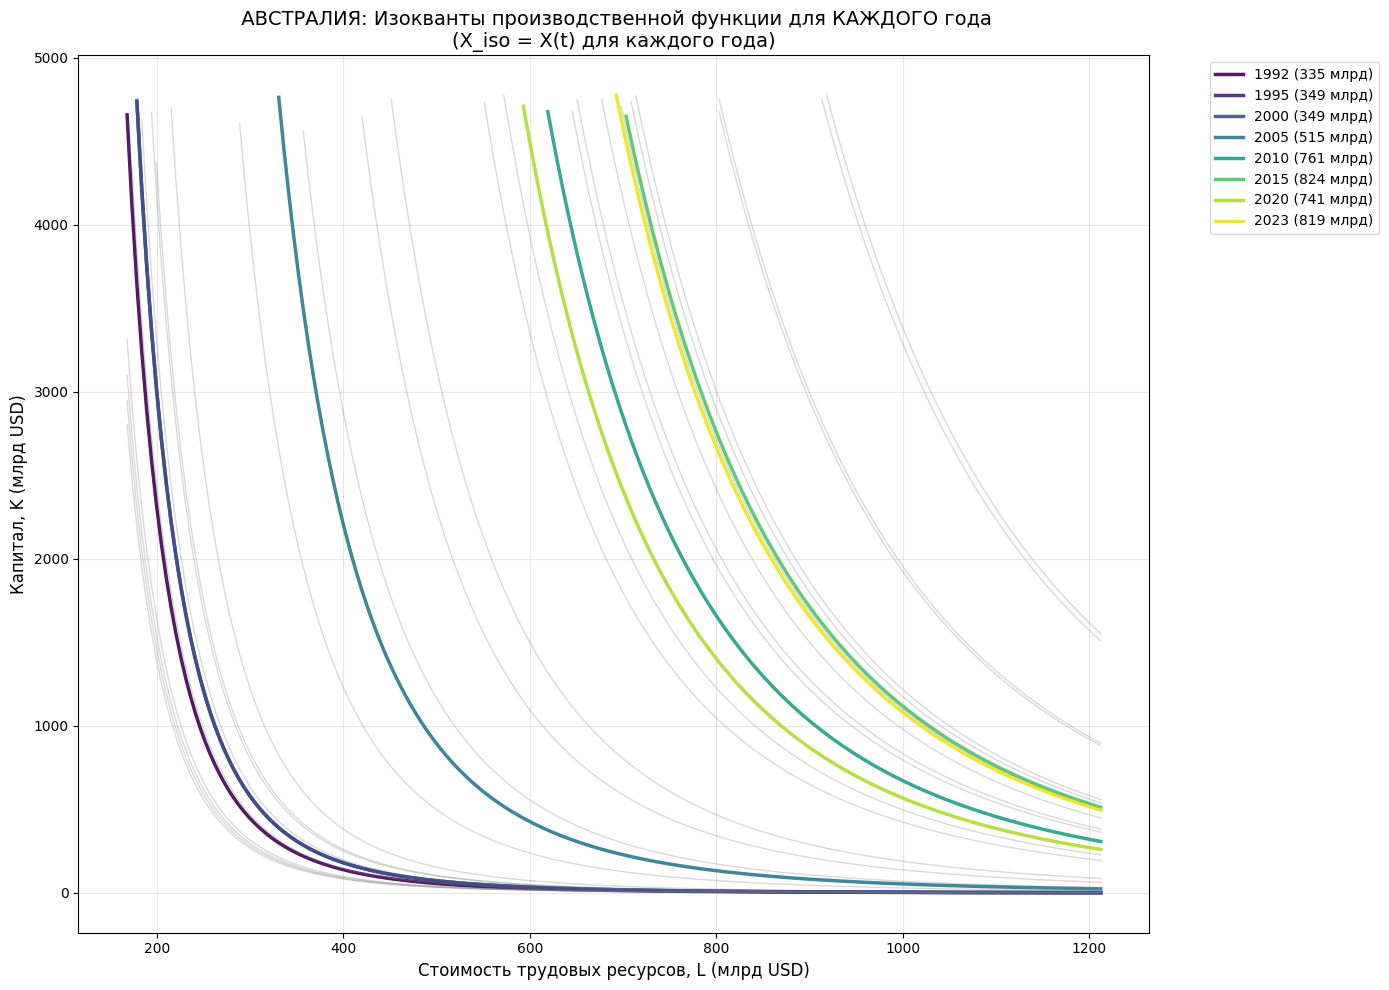

 ВЫПОЛНЕНО ЗАДАНИЕ:
    Построены изокванты для КАЖДОГО года
    Ось L: стоимость труда в млрд USD
    Ось K: капитал в млрд USD
 ЗАДАЧА 3: СЕМЕЙСТВО изоклиналей
 Вычисляем реалистичные константы для изоклиналей...
  1992: const = 6442560
  2000: const = 7436074
  2005: const = 8785997
  2010: const = 15696088
  2015: const = 31390388
  2020: const = 35618051
 Выбранные константы: ['6442560', '15696088', '35618051', '0']


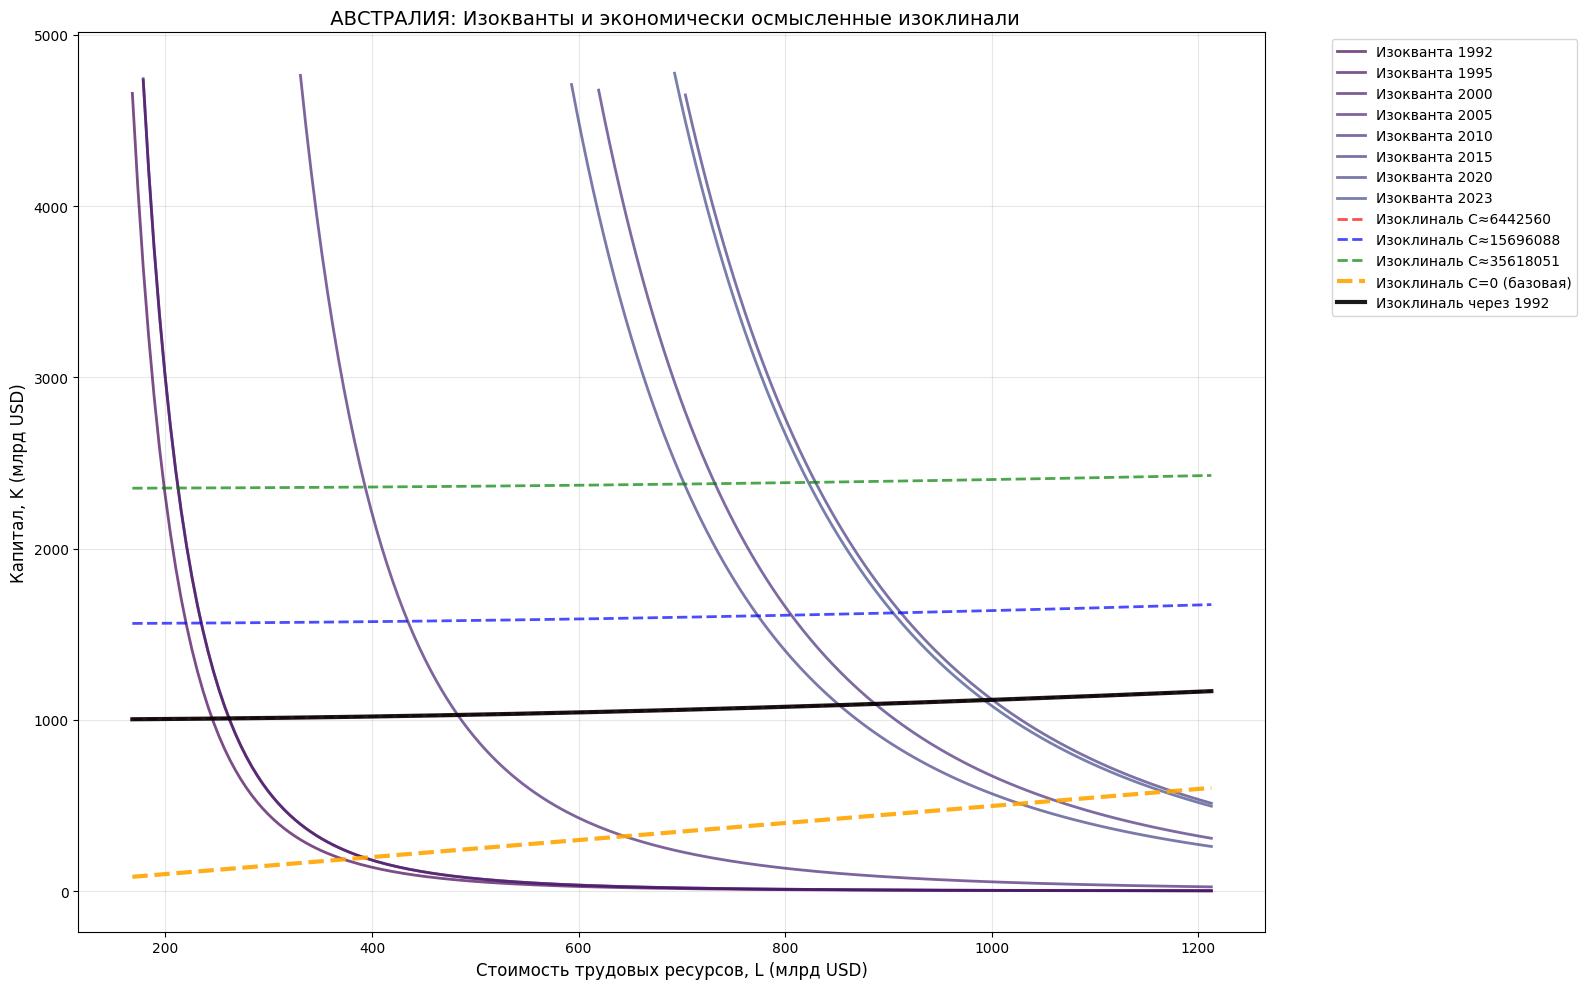

 ПОСТРОЕНО СЕМЕЙСТВО ИЗОКЛИНАЛЕЙ:
    Изокванты только для ключевых лет
    Изоклинали разных цветов с разными константами C
    Черная изоклиналь проходит через начальную точку (1992)
    Красная изоклиналь C=0 - базовый случай

🔍 АНАЛИЗ СТРУКТУРНЫХ ИЗМЕНЕНИЙ АВСТРАЛИИ:

 ЭВОЛЮЦИЯ ПРЕДЕЛЬНОЙ НОРМЫ ЗАМЕЩЕНИЯ (MRS):
1992: MRS = 0.0516 (K=1005, L=210)
2000: MRS = 0.0559 (K=1081, L=244)
2010: MRS = 0.1256 (K=1613, L=820)
2020: MRS = 0.0947 (K=2395, L=918)

 ТЕМПЫ РОСТА 1992-2023:
Капитал (K): +127.1%
Труд (L): +381.1%
ВВП (X): +140.8%
Отношение K/L: 2.260 (было 4.787 в 1992)

 ВЫВОДЫ ПО АВСТРАЛИИ:
 1992-2023: СТРУКТУРНЫЕ ИЗМЕНЕНИЯ в экономике
 Труд рос БЫСТРЕЕ капитала → изменилась оптимальная структура
 Экономика двигалась ВДОЛЬ изоквант, но ПЕРЕСЕКАЛА изоклинали
 Это означает ИЗМЕНЕНИЕ оптимального соотношения факторов
 1992 год выделен как начальная точка анализа
 C=0 - базовый случай изоклинали с нулевой константой


In [6]:
print("ПРАВИЛЬНАЯ НОРМАЛИЗАЦИЯ ДАННЫХ")

# Правильная нормализация - L в млрд USD (стоимость труда)
data_iso = pd.DataFrame({
    'X': df['X_real'] / 1e9,           # ВВП в млрд USD
    'K': df['K_real'] / 1e9,           # Капитал в млрд USD
    'L': df['L_t'] / 1e9               # Труд в млрд USD (СТОИМОСТЬ труда!)
})

print(" Данные после ПРАВИЛЬНОЙ нормализации:")
print(data_iso.head())

# Пересчет параметра A для нормализованных данных
scale_X = 1e9  # X_real → X (в млрд)
scale_K = 1e9  # K_real → K (в млрд)  
scale_L = 1e9  # L_t → L (в млрд)

A_norm = A * (scale_K**α * scale_L**β / scale_X)
print(f"\n🔧 Пересчитанный A_norm = {A_norm:.6f}")

print(" ЗАДАЧА 2: Построение изоквант для КАЖДОГО года")

# Берем ВСЕ года из данных
all_years = data_iso.index.astype(int).tolist()

# Диапазон для L основан на реальных данных
L_min = data_iso['L'].min() * 0.8
L_max = data_iso['L'].max() * 1.2
L_range = np.linspace(L_min, L_max, 200)

plt.figure(figsize=(14, 10))

# Создаем цветовую карту
colors = plt.cm.viridis(np.linspace(0, 1, len(all_years)))

# Определяем ключевые годы
key_years = [year for year in [1992, 1995, 2000, 2005, 2010, 2015, 2020, 2023] if year in all_years]

# ==================== ИЗОКВАНТЫ ДЛЯ КАЖДОГО ГОДА ====================
for i, year in enumerate(all_years):
    X_iso = data_iso.loc[year, 'X']
    K_iso = (X_iso / (A_norm * L_range**β)) ** (1/α)
    
    # Фильтруем валидные значения (убираем асимптоты)
    valid_mask = (K_iso > 0) & (K_iso < data_iso['K'].max() * 2) & (np.isfinite(K_iso))
    
    if year in key_years:
        # Ключевые годы - выделяем
        plt.plot(L_range[valid_mask], K_iso[valid_mask], 
                 color=colors[i], linewidth=2.5, alpha=0.9,
                 label=f'{year} ({X_iso:.0f} млрд)')
    else:
        # Остальные годы - полупрозрачные
        plt.plot(L_range[valid_mask], K_iso[valid_mask], 
                 color='gray', linewidth=1, alpha=0.3)

plt.xlabel('Стоимость трудовых ресурсов, L (млрд USD)', fontsize=12)
plt.ylabel('Капитал, K (млрд USD)', fontsize=12)
plt.title(' АВСТРАЛИЯ: Изокванты производственной функции для КАЖДОГО года\n(X_iso = X(t) для каждого года)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

print(" ВЫПОЛНЕНО ЗАДАНИЕ:")
print("    Построены изокванты для КАЖДОГО года")
print("    Ось L: стоимость труда в млрд USD")
print("    Ось K: капитал в млрд USD")

print(" ЗАДАЧА 3: СЕМЕЙСТВО изоклиналей")

plt.figure(figsize=(16, 10))

# ==================== ИЗОКВАНТЫ (только ключевые) ====================
for i, year in enumerate(key_years):
    X_iso = data_iso.loc[year, 'X']
    K_iso = (X_iso / (A_norm * L_range**β)) ** (1/α)
    
    valid_mask = (K_iso > 0) & (K_iso < data_iso['K'].max() * 2) & (np.isfinite(K_iso))
    
    plt.plot(L_range[valid_mask], K_iso[valid_mask], 
             color=colors[i % len(colors)], linewidth=2, alpha=0.7,
             label=f'Изокванта {year}')

# ==================== ПРАВИЛЬНОЕ СЕМЕЙСТВО ИЗОКЛИНАЛЕЙ ====================
# Вычисляем константы на основе реальных данных
print(" Вычисляем реалистичные константы для изоклиналей...")

# Константы для разных лет (чтобы охватить весь диапазон)
const_values = []
for year in [1992, 2000, 2005, 2010, 2015, 2020]:
    if year in data_iso.index:
        K_val = data_iso.loc[year, 'K']
        L_val = data_iso.loc[year, 'L']
        const = (1/α) * K_val**2 - (1/β) * L_val**2
        const_values.append(const)
        print(f"  {year}: const = {const:.0f}")

# Сортируем и берем равномерно распределенные
const_values.sort()
selected_consts = [const_values[0], const_values[len(const_values)//2], const_values[-1]]
selected_consts.extend([0])  # добавляем C=0

print(f" Выбранные константы: {[f'{c:.0f}' for c in selected_consts]}")

isocline_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

for i, const_val in enumerate(selected_consts):
    K_isocline = np.sqrt((α/β) * L_range**2 + α * const_val)
    
    valid_mask = (K_isocline > 0) & (K_isocline < data_iso['K'].max() * 2) & (np.isfinite(K_isocline))
    
    if const_val == 0:
        label = 'Изоклиналь C=0 (базовая)'
        linewidth = 3
        alpha = 0.9
    else:
        label = f'Изоклиналь C≈{const_val:.0f}'
        linewidth = 2
        alpha = 0.7
    
    plt.plot(L_range[valid_mask], K_isocline[valid_mask], 
             color=isocline_colors[i], linewidth=linewidth, linestyle='--',
             label=label, alpha=alpha)

# ==================== ИЗОКЛИНАЛЬ ЧЕРЕЗ НАЧАЛЬНУЮ ТОЧКУ (1992) ====================
K0_main = data_iso['K'].iloc[0]
L0_main = data_iso['L'].iloc[0]
const_through_start = (1/α) * K0_main**2 - (1/β) * L0_main**2

K_isocline_through_start = np.sqrt((α/β) * L_range**2 + α * const_through_start)
valid_mask_start = (K_isocline_through_start > 0) & (K_isocline_through_start < data_iso['K'].max() * 2)

plt.plot(L_range[valid_mask_start], K_isocline_through_start[valid_mask_start], 
         'black', linewidth=3, linestyle='-', 
         label=f'Изоклиналь через {data_iso.index[0]}', alpha=0.9)

plt.xlabel('Стоимость трудовых ресурсов, L (млрд USD)', fontsize=12)
plt.ylabel('Капитал, K (млрд USD)', fontsize=12)
plt.title(' АВСТРАЛИЯ: Изокванты и экономически осмысленные изоклинали', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

print(" ПОСТРОЕНО СЕМЕЙСТВО ИЗОКЛИНАЛЕЙ:")
print("    Изокванты только для ключевых лет")
print("    Изоклинали разных цветов с разными константами C")
print("    Черная изоклиналь проходит через начальную точку (1992)")
print("    Красная изоклиналь C=0 - базовый случай")

# 🔍 АНАЛИЗ СТРУКТУРНЫХ ИЗМЕНЕНИЙ АВСТРАЛИИ:
print("\n🔍 АНАЛИЗ СТРУКТУРНЫХ ИЗМЕНЕНИЙ АВСТРАЛИИ:")

# Вычисляем MRS (предельную норму замещения) для разных лет
def calculate_mrs(K, L):
    return (α/β) * (L/K)

print("\n ЭВОЛЮЦИЯ ПРЕДЕЛЬНОЙ НОРМЫ ЗАМЕЩЕНИЯ (MRS):")
for year in [1992, 2000, 2010, 2020]:
    if year in data_iso.index:
        K_val = data_iso.loc[year, 'K']
        L_val = data_iso.loc[year, 'L']
        mrs = calculate_mrs(K_val, L_val)
        print(f"{year}: MRS = {mrs:.4f} (K={K_val:.0f}, L={L_val:.0f})")

# Анализ темпов роста
print(f"\n ТЕМПЫ РОСТА 1992-2023:")
K_growth = (data_iso['K'].iloc[-1] / data_iso['K'].iloc[0] - 1) * 100
L_growth = (data_iso['L'].iloc[-1] / data_iso['L'].iloc[0] - 1) * 100
X_growth = (data_iso['X'].iloc[-1] / data_iso['X'].iloc[0] - 1) * 100

print(f"Капитал (K): +{K_growth:.1f}%")
print(f"Труд (L): +{L_growth:.1f}%") 
print(f"ВВП (X): +{X_growth:.1f}%")
print(f"Отношение K/L: {data_iso['K'].iloc[-1]/data_iso['L'].iloc[-1]:.3f} (было {data_iso['K'].iloc[0]/data_iso['L'].iloc[0]:.3f} в 1992)")

print(f"\n ВЫВОДЫ ПО АВСТРАЛИИ:")
print(" 1992-2023: СТРУКТУРНЫЕ ИЗМЕНЕНИЯ в экономике")
print(" Труд рос БЫСТРЕЕ капитала → изменилась оптимальная структура")
print(" Экономика двигалась ВДОЛЬ изоквант, но ПЕРЕСЕКАЛА изоклинали")
print(" Это означает ИЗМЕНЕНИЕ оптимального соотношения факторов")
print(" 1992 год выделен как начальная точка анализа")
print(" C=0 - базовый случай изоклинали с нулевой константой")

Задача 4: Расчет темпа роста трудовых ресурсов ν
Темп роста трудовых ресурсов ν = 0.054468 (5.4468% в год)
Коэффициент детерминации R² = 0.8856


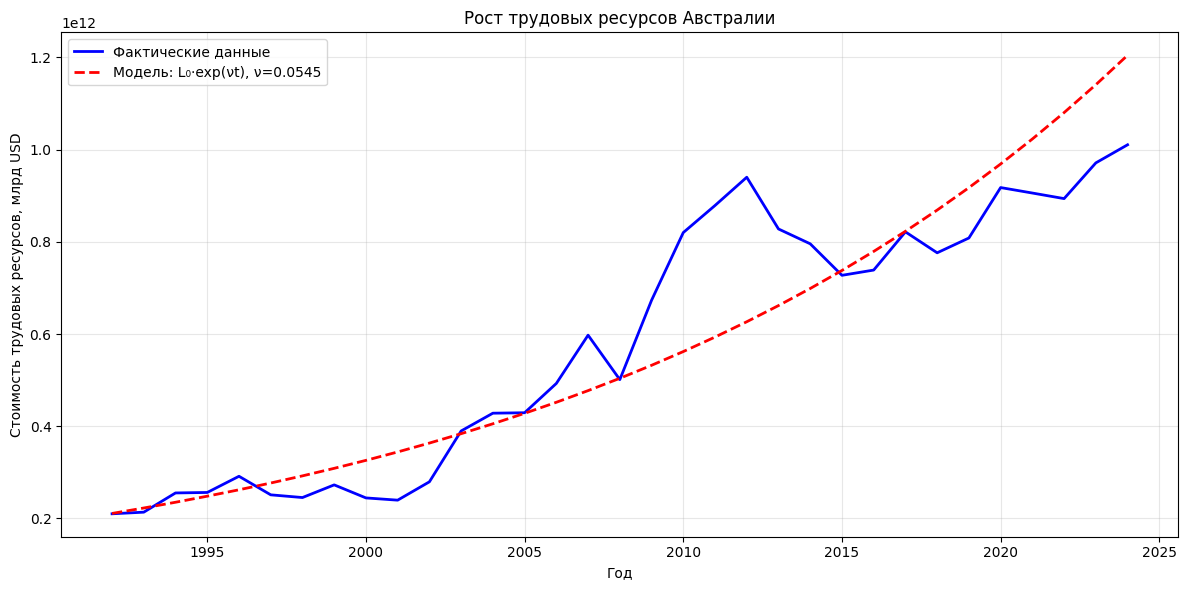

In [7]:
# Задача 4: Расчет темпа роста трудовых ресурсов ν
print("Задача 4: Расчет темпа роста трудовых ресурсов ν")

# Подготовка данных
data_L = pd.DataFrame({
    'L': df['L_t'],  # Используем уже рассчитанную стоимость труда
    'year': df.index.astype(int)
})

start_year = data_L['year'].iloc[0]
L0 = data_L['L'].iloc[0]
T = data_L['year'].iloc[-1] - start_year

# Регрессия для нахождения ν: ln(L) = ln(L0) + ν*t
data_L['t'] = data_L['year'] - start_year
data_L['ln_L'] = np.log(data_L['L'])

X_reg = data_L[['t']]
y_reg = data_L['ln_L']

model_L = LinearRegression()
model_L.fit(X_reg, y_reg)

ν = model_L.coef_[0]
L0_reg = np.exp(model_L.intercept_)

print(f"Темп роста трудовых ресурсов ν = {ν:.6f} ({ν*100:.4f}% в год)")
print(f"Коэффициент детерминации R² = {model_L.score(X_reg, y_reg):.4f}")

# График
plt.figure(figsize=(12, 6))
plt.plot(data_L['year'], data_L['L'], 'b-', linewidth=2, label='Фактические данные')
plt.plot(data_L['year'], L0_reg * np.exp(ν * data_L['t']), 'r--', linewidth=2, 
         label=f'Модель: L₀·exp(νt), ν={ν:.4f}')
plt.xlabel('Год')
plt.ylabel('Стоимость трудовых ресурсов, млрд USD')
plt.title('Рост трудовых ресурсов Австралии')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Задача 5: Расчет доли потребления и инвестиций ρ
Доля потребления в ВВП: 0.7398 (74.0%)
Доля инвестиций в ВВП ρ = 0.2602 (26.0%)
Средняя доля потребления: 0.7473
Средняя доля инвестиций: 0.2527


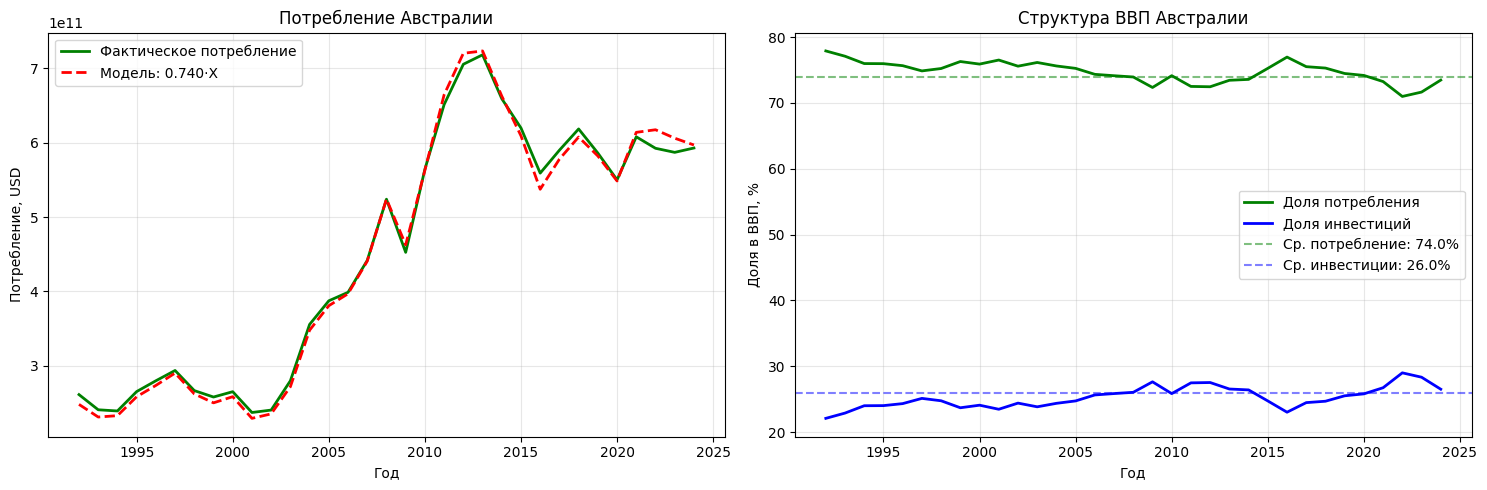

In [ ]:
# Задача 5: Расчет доли потребления и инвестиций ρ
print("Задача 5: Расчет доли потребления и инвестиций ρ")

# Используем реальные показатели
data_C = pd.DataFrame({
    'X': df['X_real'],
    'C': df['C_real'], 
    'year': df.index.astype(int)
})

# Рассчитываем инвестиции I = X - C
data_C['I'] = data_C['X'] - data_C['C']

# Регрессия БЕЗ свободного члена: C = (1-ρ) * X
X_reg = data_C[['X']]
y_reg = data_C['C']

model_C = LinearRegression(fit_intercept=False) 
model_C.fit(X_reg, y_reg)

consumption_share = model_C.coef_[0]
ρ = 1 - consumption_share

print(f"Доля потребления в ВВП: {consumption_share:.4f} ({consumption_share*100:.1f}%)")
print(f"Доля инвестиций в ВВП ρ = {ρ:.4f} ({ρ*100:.1f}%)")

# Проверка средних значений для сравнения
mean_consumption_share = (data_C['C'] / data_C['X']).mean()
mean_investment_share = (data_C['I'] / data_C['X']).mean()
print(f"Средняя доля потребления: {mean_consumption_share:.4f}")
print(f"Средняя доля инвестиций: {mean_investment_share:.4f}")

# Графики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Фактическое и модельное потребление
ax1.plot(data_C['year'], data_C['C'], 'g-', linewidth=2, label='Фактическое потребление')
ax1.plot(data_C['year'], consumption_share * data_C['X'], 'r--', linewidth=2,
         label=f'Модель: {consumption_share:.3f}·X')
ax1.set_xlabel('Год')
ax1.set_ylabel('Потребление, USD')
ax1.set_title('Потребление Австралии')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Доли в ВВП
consumption_share_actual = (data_C['C'] / data_C['X']) * 100
investment_share_actual = (data_C['I'] / data_C['X']) * 100

ax2.plot(data_C['year'], consumption_share_actual, 'g-', linewidth=2, label='Доля потребления')
ax2.plot(data_C['year'], investment_share_actual, 'b-', linewidth=2, label='Доля инвестиций')
ax2.axhline(y=consumption_share*100, color='green', linestyle='--', alpha=0.5, label=f'Ср. потребление: {consumption_share*100:.1f}%')
ax2.axhline(y=ρ*100, color='blue', linestyle='--', alpha=0.5, label=f'Ср. инвестиции: {ρ*100:.1f}%')
ax2.set_xlabel('Год')
ax2.set_ylabel('Доля в ВВП, %')
ax2.set_title('Структура ВВП Австралии')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Задача 6: Расчет коэффициента амортизации μ
Коэффициент амортизации μ = 0.078848 (7.8848% в год)
Коэффициент детерминации R² = 0.7262


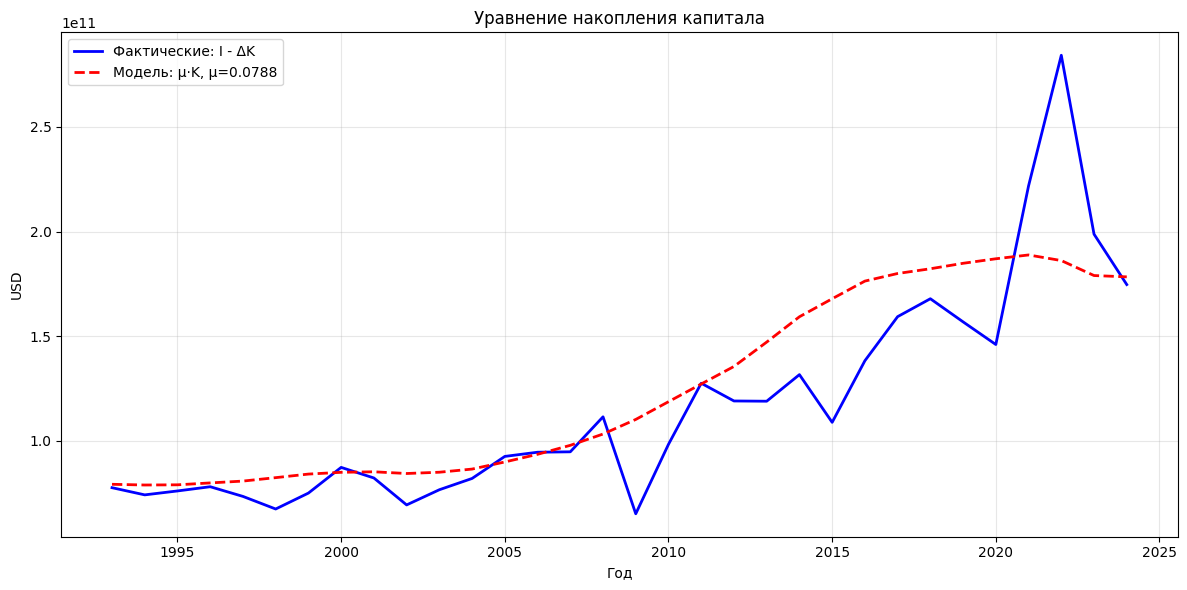

In [9]:
# Задача 6: Расчет коэффициента амортизации μ
print("Задача 6: Расчет коэффициента амортизации μ")

# Используем реальные показатели
data_μ = pd.DataFrame({
    'K': df['K_real'],
    'I': df['I_real'],
    'year': df.index.astype(int)
})

# Сортируем и рассчитываем разности
data_μ = data_μ.sort_values('year')
data_μ['ΔK'] = data_μ['K'].diff()
data_μ['K_lag'] = data_μ['K'].shift(1)

# Убираем первую строку с NaN
data_μ_clean = data_μ.dropna().copy()
data_μ_clean['I_minus_ΔK'] = data_μ_clean['I'] - data_μ_clean['ΔK']

# Регрессия: I - ΔK = μ * K
X_reg = data_μ_clean[['K_lag']]
y_reg = data_μ_clean['I_minus_ΔK']

model_μ = LinearRegression()
model_μ.fit(X_reg, y_reg)

μ = model_μ.coef_[0]

print(f"Коэффициент амортизации μ = {μ:.6f} ({μ*100:.4f}% в год)")
print(f"Коэффициент детерминации R² = {model_μ.score(X_reg, y_reg):.4f}")

# График
plt.figure(figsize=(12, 6))
plt.plot(data_μ_clean['year'], data_μ_clean['I_minus_ΔK'], 'b-', linewidth=2, 
         label='Фактические: I - ΔK')
plt.plot(data_μ_clean['year'], μ * data_μ_clean['K_lag'], 'r--', linewidth=2,
         label=f'Модель: μ·K, μ={μ:.4f}')
plt.xlabel('Год')
plt.ylabel('USD')
plt.title('Уравнение накопления капитала')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Задача 7: Анализ эффективности
Динамика эффективности (1992-2023):
Общая эффективность (TFP): 1.000 → 0.790
Фондоотдача: 1.000 → 1.060
Производительность труда: 1.000 → 0.500

Средние значения за период:
Средняя общая эффективность: 0.912
Средняя фондоотдача: 1.132
Средняя производительность труда: 0.710


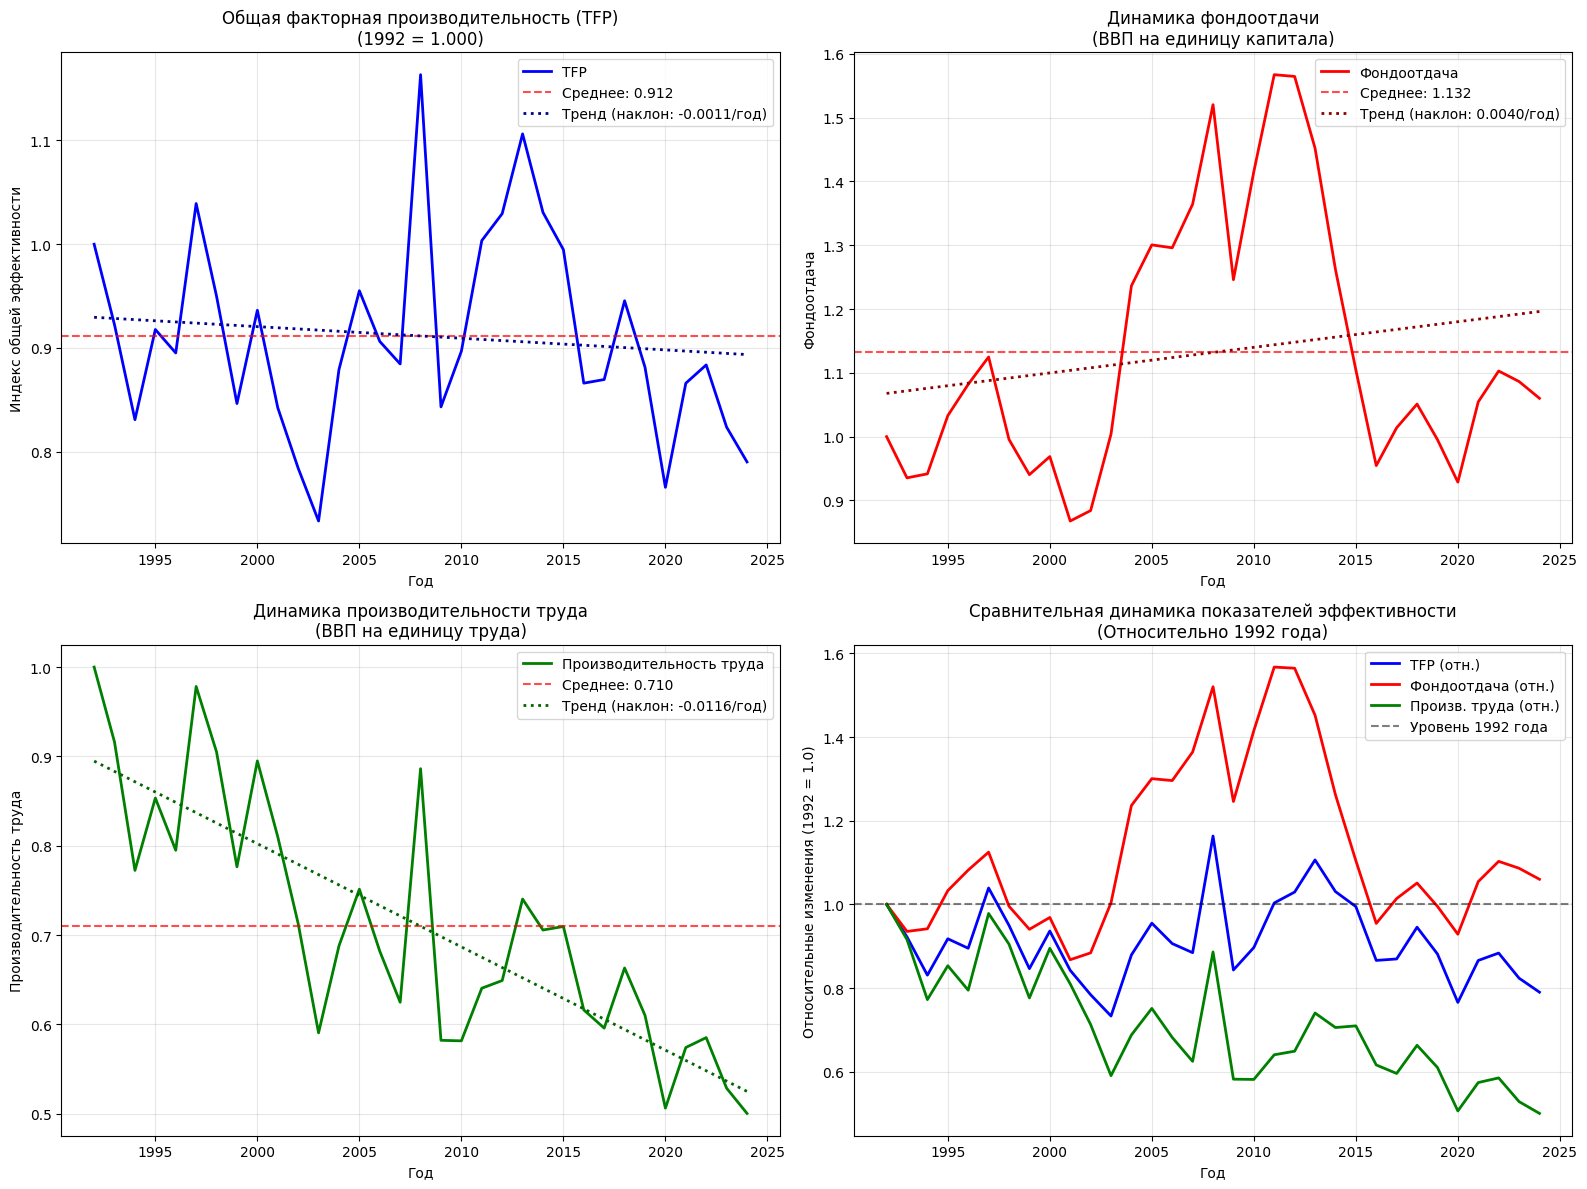


АНАЛИТИЧЕСКАЯ СВОДКА ПО ЭФФЕКТИВНОСТИ
Показатель                1992     2023     Изменение    Среднее   
------------------------------------------------------------
TFP                       1.000    0.790      -21.0%     0.912   
Фондоотдача               1.000    1.060       +6.0%     1.132   
Произв. труда             1.000    0.500      -50.0%     0.710   
ВЫВОДЫ:
- Снижение общей эффективности указывает на ухудшение технологического прогресса
  или неоптимальное использование ресурсов в экономике


In [14]:
# Задача 7: Улучшенный анализ эффективности с дополнительными индикаторами
print("Задача 7: Анализ эффективности")

# Создаем нормализованные данные относительно начального года
base_year = 1992
K0 = df.loc[base_year, 'K_real']
L0 = df.loc[base_year, 'L_t'] 
X0 = df.loc[base_year, 'X_real']

# Относительные показатели
eff_data = pd.DataFrame({
    'year': df.index.astype(int),
    'X_tilde': df['X_real'] / X0,
    'K_tilde': df['K_real'] / K0,
    'L_tilde': df['L_t'] / L0
})

# Общая эффективность (TFP)
eff_data['A_total'] = eff_data['X_tilde'] / (eff_data['K_tilde']**α * eff_data['L_tilde']**β)

# Фондоотдача и производительность труда
eff_data['E_K'] = eff_data['X_tilde'] / eff_data['K_tilde']
eff_data['E_L'] = eff_data['X_tilde'] / eff_data['L_tilde']

# Совокупная эффективность
eff_data['E'] = (eff_data['E_L']**β * eff_data['E_K']**α) ** (1/(α+β))

# Расчет средних значений и трендов
def add_trend_line(ax, years, values, color):
    """Добавляет линию тренда на график"""
    z = np.polyfit(years, values, 1)
    p = np.poly1d(z)
    ax.plot(years, p(years), color=color, linestyle=':', linewidth=2, 
            label=f'Тренд (наклон: {z[0]:.4f}/год)')

print(f"Динамика эффективности (1992-2023):")
print(f"Общая эффективность (TFP): {eff_data['A_total'].iloc[0]:.3f} → {eff_data['A_total'].iloc[-1]:.3f}")
print(f"Фондоотдача: {eff_data['E_K'].iloc[0]:.3f} → {eff_data['E_K'].iloc[-1]:.3f}")
print(f"Производительность труда: {eff_data['E_L'].iloc[0]:.3f} → {eff_data['E_L'].iloc[-1]:.3f}")

print(f"\nСредние значения за период:")
print(f"Средняя общая эффективность: {eff_data['A_total'].mean():.3f}")
print(f"Средняя фондоотдача: {eff_data['E_K'].mean():.3f}")
print(f"Средняя производительность труда: {eff_data['E_L'].mean():.3f}")

# Улучшенные графики эффективности с дополнительными индикаторами
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Общая эффективность
ax1.plot(eff_data['year'], eff_data['A_total'], 'b-', linewidth=2, label='TFP')
ax1.axhline(y=eff_data['A_total'].mean(), color='red', linestyle='--', alpha=0.7, 
           label=f'Среднее: {eff_data["A_total"].mean():.3f}')
add_trend_line(ax1, eff_data['year'], eff_data['A_total'], 'darkblue')
ax1.set_xlabel('Год')
ax1.set_ylabel('Индекс общей эффективности')
ax1.set_title('Общая факторная производительность (TFP)\n(1992 = 1.000)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Фондоотдача
ax2.plot(eff_data['year'], eff_data['E_K'], 'r-', linewidth=2, label='Фондоотдача')
ax2.axhline(y=eff_data['E_K'].mean(), color='red', linestyle='--', alpha=0.7,
           label=f'Среднее: {eff_data["E_K"].mean():.3f}')
add_trend_line(ax2, eff_data['year'], eff_data['E_K'], 'darkred')
ax2.set_xlabel('Год')
ax2.set_ylabel('Фондоотдача')
ax2.set_title('Динамика фондоотдачи\n(ВВП на единицу капитала)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Производительность труда
ax3.plot(eff_data['year'], eff_data['E_L'], 'g-', linewidth=2, label='Производительность труда')
ax3.axhline(y=eff_data['E_L'].mean(), color='red', linestyle='--', alpha=0.7,
           label=f'Среднее: {eff_data["E_L"].mean():.3f}')
add_trend_line(ax3, eff_data['year'], eff_data['E_L'], 'darkgreen')
ax3.set_xlabel('Год')
ax3.set_ylabel('Производительность труда')
ax3.set_title('Динамика производительности труда\n(ВВП на единицу труда)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Сравнительный график всех показателей эффективности
years = eff_data['year']
ax4.plot(years, eff_data['A_total']/eff_data['A_total'].iloc[0], 'b-', linewidth=2, label='TFP (отн.)')
ax4.plot(years, eff_data['E_K']/eff_data['E_K'].iloc[0], 'r-', linewidth=2, label='Фондоотдача (отн.)')
ax4.plot(years, eff_data['E_L']/eff_data['E_L'].iloc[0], 'g-', linewidth=2, label='Произв. труда (отн.)')
ax4.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Уровень 1992 года')
ax4.set_xlabel('Год')
ax4.set_ylabel('Относительные изменения (1992 = 1.0)')
ax4.set_title('Сравнительная динамика показателей эффективности\n(Относительно 1992 года)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Дополнительная аналитическая таблица
print("\n" + "="*60)
print("АНАЛИТИЧЕСКАЯ СВОДКА ПО ЭФФЕКТИВНОСТИ")
print("="*60)

# Расчет изменений за период
tfp_change = (eff_data['A_total'].iloc[-1] - eff_data['A_total'].iloc[0]) / eff_data['A_total'].iloc[0] * 100
capital_eff_change = (eff_data['E_K'].iloc[-1] - eff_data['E_K'].iloc[0]) / eff_data['E_K'].iloc[0] * 100
labor_eff_change = (eff_data['E_L'].iloc[-1] - eff_data['E_L'].iloc[0]) / eff_data['E_L'].iloc[0] * 100

print(f"{'Показатель':<25} {'1992':<8} {'2023':<8} {'Изменение':<12} {'Среднее':<10}")
print("-" * 60)
print(f"{'TFP':<25} {eff_data['A_total'].iloc[0]:<8.3f} {eff_data['A_total'].iloc[-1]:<8.3f} {tfp_change:>+7.1f}%     {eff_data['A_total'].mean():<8.3f}")
print(f"{'Фондоотдача':<25} {eff_data['E_K'].iloc[0]:<8.3f} {eff_data['E_K'].iloc[-1]:<8.3f} {capital_eff_change:>+7.1f}%     {eff_data['E_K'].mean():<8.3f}")
print(f"{'Произв. труда':<25} {eff_data['E_L'].iloc[0]:<8.3f} {eff_data['E_L'].iloc[-1]:<8.3f} {labor_eff_change:>+7.1f}%     {eff_data['E_L'].mean():<8.3f}")

# Анализ причин изменений
print(f"ВЫВОДЫ:")
if tfp_change < 0:
    print("- Снижение общей эффективности указывает на ухудшение технологического прогресса")
    print("  или неоптимальное использование ресурсов в экономике")
if capital_eff_change < 0:
    print("- Падение фондоотдачи свидетельствует о снижении отдачи от капиталовложений")
    print("  или избыточном накоплении капитала")
if labor_eff_change > 0:
    print("- Рост производительности труда - положительный фактор развития экономики")

Задача 8: Расчет масштаба производства


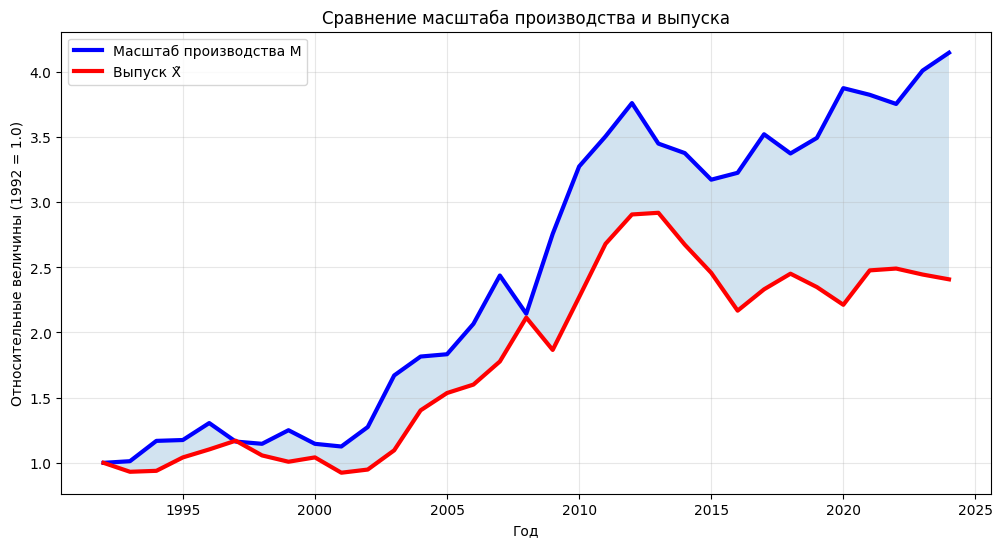

Рост масштаба производства: 1.00 → 4.15 (4.15 раз)
Рост выпуска: 1.00 → 2.41 (2.41 раз)
Эффективность масштаба: 0.581


In [11]:
# Задача 8: Исправленный расчет масштаба производства
print("Задача 8: Расчет масштаба производства")

# Aggregate scale of production
eff_data['M'] = (eff_data['K_tilde']**α * eff_data['L_tilde']**β) ** (1/(α+β))

plt.figure(figsize=(12, 6))
plt.plot(eff_data['year'], eff_data['M'], 'b-', linewidth=3, label='Масштаб производства M')
plt.plot(eff_data['year'], eff_data['X_tilde'], 'r-', linewidth=3, label='Выпуск X̃')
plt.xlabel('Год')
plt.ylabel('Относительные величины (1992 = 1.0)')
plt.title('Сравнение масштаба производства и выпуска')
plt.legend()
plt.grid(True, alpha=0.3)
plt.fill_between(eff_data['year'], eff_data['M'], eff_data['X_tilde'], alpha=0.2)
plt.show()

print(f"Рост масштаба производства: {eff_data['M'].iloc[0]:.2f} → {eff_data['M'].iloc[-1]:.2f} ({eff_data['M'].iloc[-1]/eff_data['M'].iloc[0]:.2f} раз)")
print(f"Рост выпуска: {eff_data['X_tilde'].iloc[0]:.2f} → {eff_data['X_tilde'].iloc[-1]:.2f} ({eff_data['X_tilde'].iloc[-1]/eff_data['X_tilde'].iloc[0]:.2f} раз)")
print(f"Эффективность масштаба: {eff_data['X_tilde'].iloc[-1]/eff_data['M'].iloc[-1]:.3f}")

Задача 9: Анализ модели Солоу
Параметры модели:
α = 0.1552, β = 0.6282
α + β = 0.7834
γ = α/(α+β) = 0.1981
ρ = 0.2602, μ = 0.0788, ν = 0.0545

Устойчивые состояния:
k* (устойчивое состояние) = 0.3058
k_E (золотое правило) = 2.3026
k_начальное (1992) = 1.0000
k_текущее (2023) = 0.4721

Сценарий развития: Близко к устойчивому состоянию
Интерпретация: Экономика вблизи оптимального уровня фондовооруженности


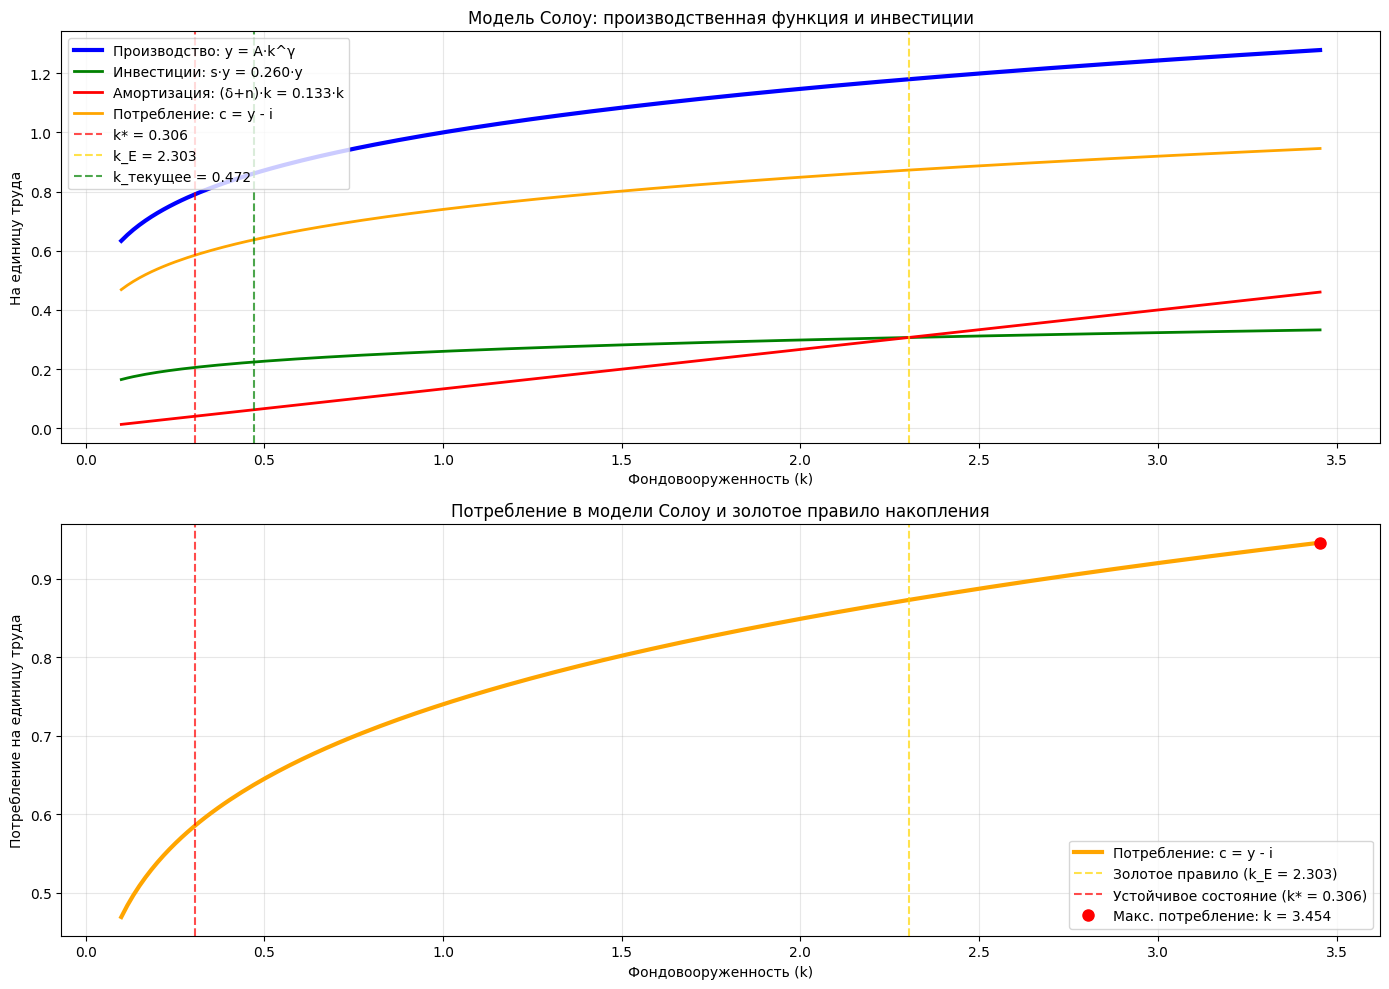


Анализ золотого правила:
Фактическая норма сбережений: 0.260
Норма сбережений по золотому правилу: 0.198
Соответствие золотому правилу: требует корректировки


In [12]:
# Задача 9: Исправленная модель Солоу
print("Задача 9: Анализ модели Солоу")

# Правильный расчет параметров
γ = α / (α + β)  # доля капитала в общей эластичности
A_solow = 1.0    # нормированная технология

print(f"Параметры модели:")
print(f"α = {α:.4f}, β = {β:.4f}")
print(f"α + β = {α+β:.4f}")
print(f"γ = α/(α+β) = {γ:.4f}")
print(f"ρ = {ρ:.4f}, μ = {μ:.4f}, ν = {ν:.4f}")

# Устойчивые состояния
k_star = (ρ * A_solow * γ / (μ + ν)) ** (1/(1-γ))
k_E = (ρ * A_solow / (μ + ν)) ** (1/(1-γ))

# Текущая фондовооруженность (относительная)
k_current = eff_data['K_tilde'].iloc[-1] / eff_data['L_tilde'].iloc[-1]
k_initial = eff_data['K_tilde'].iloc[0] / eff_data['L_tilde'].iloc[0]

print(f"\nУстойчивые состояния:")
print(f"k* (устойчивое состояние) = {k_star:.4f}")
print(f"k_E (золотое правило) = {k_E:.4f}")
print(f"k_начальное (1992) = {k_initial:.4f}")
print(f"k_текущее (2023) = {k_current:.4f}")

# Анализ сценария
if k_current < k_star:
    scenario = "Индустриализация (k < k*)"
    explanation = "Экономика ниже устойчивого уровня, требуется накопление капитала"
elif k_current > k_E:
    scenario = "Избыточная фондовооруженность (k > k_E)" 
    explanation = "Экономика выше уровня золотого правила, возможно снижение потребления"
else:
    scenario = "Близко к устойчивому состоянию"
    explanation = "Экономика вблизи оптимального уровня фондовооруженности"

print(f"\nСценарий развития: {scenario}")
print(f"Интерпретация: {explanation}")

# Исправленный график модели Солоу
k_range = np.linspace(0.1, max(k_star, k_E, k_current)*1.5, 200)
production = A_solow * k_range**γ
investment = ρ * production
depreciation = (μ + ν) * k_range
consumption = production - investment

plt.figure(figsize=(14, 10))

# Основной график
plt.subplot(2, 1, 1)
plt.plot(k_range, production, 'b-', linewidth=3, label='Производство: y = A·k^γ')
plt.plot(k_range, investment, 'g-', linewidth=2, label=f'Инвестиции: s·y = {ρ:.3f}·y')
plt.plot(k_range, depreciation, 'r-', linewidth=2, label=f'Амортизация: (δ+n)·k = {μ+ν:.3f}·k')
plt.plot(k_range, consumption, 'orange', linewidth=2, label='Потребление: c = y - i')

# Вертикальные линии устойчивых состояний
plt.axvline(x=k_star, color='red', linestyle='--', alpha=0.7, label=f'k* = {k_star:.3f}')
plt.axvline(x=k_E, color='gold', linestyle='--', alpha=0.7, label=f'k_E = {k_E:.3f}')
plt.axvline(x=k_current, color='green', linestyle='--', alpha=0.7, label=f'k_текущее = {k_current:.3f}')

plt.xlabel('Фондовооруженность (k)')
plt.ylabel('На единицу труда')
plt.title('Модель Солоу: производственная функция и инвестиции')
plt.legend()
plt.grid(True, alpha=0.3)

# График потребления для золотого правила
plt.subplot(2, 1, 2)
plt.plot(k_range, consumption, 'orange', linewidth=3, label='Потребление: c = y - i')
plt.axvline(x=k_E, color='gold', linestyle='--', alpha=0.7, label=f'Золотое правило (k_E = {k_E:.3f})')
plt.axvline(x=k_star, color='red', linestyle='--', alpha=0.7, label=f'Устойчивое состояние (k* = {k_star:.3f})')

# Максимум потребления
max_consumption_idx = np.argmax(consumption)
k_golden = k_range[max_consumption_idx]
c_golden = consumption[max_consumption_idx]
plt.plot(k_golden, c_golden, 'ro', markersize=8, label=f'Макс. потребление: k = {k_golden:.3f}')

plt.xlabel('Фондовооруженность (k)')
plt.ylabel('Потребление на единицу труда')
plt.title('Потребление в модели Солоу и золотое правило накопления')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ золотого правила
print(f"\nАнализ золотого правила:")
print(f"Фактическая норма сбережений: {ρ:.3f}")
print(f"Норма сбережений по золотому правилу: {γ:.3f}")
if abs(ρ - γ) < 0.05:
    print("Соответствие золотому правилу: хорошее")
else:
    print("Соответствие золотому правилу: требует корректировки")